<a href="https://colab.research.google.com/github/zzl-hyun/2024-JBNU-/blob/main/analyze_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'jbnu-2024-ai-competitons:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F75445%2F8308692%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240927%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240927T005426Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5ce12fdafb4e90e2b49a6d74cfc41875a9a7e07f55f2dd5544c6c951b07a18bd90f6c99b9cc6462791aa064fa98edbea5c4a787de908c82479950950da7f8c0454806b2ce8f9039a253a720bf4312222e7c0f918b3eca916c42b6b758ad8d839131227fdd8434941d0ce1272ac380c85541f861dd194a6141fa772fefde8c5dae0d991123af105cfdfd11744a79ade5502447a11cf08f0004189bce7a7946e64569734a2eb400de24a71c1e5c5df0f9b79448d5ae6f74d256184915df1fd0155d62acfd5fe7805d80e356a699798160b6dc32e637efc04b54b049dcd150870d02c01946e5d66a147b332f30e38a0352ce2d8afb94791b98900ae2f92f791eaf1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


강의자료 링크

https://drive.google.com/file/d/1zACL0lRB5x0toE8SaHz2q7OBr02yXqws/view?usp=sharing

문의:
컴퓨터인공지능학부 이세호

Office: 공과대학 7호관 425호 (063-270-2417)

Phone: 010-2715-5362

E-Mail: seholee@jbnu.ac.kr


## Library 설정 및 필요 함수 정의

수정 필요 없음

**find_wav_files**: 디렉토리 내에 있는 .wav 파일들을 리스트화하는 함수

**set_seed**: 랜덤 시드 설정에 대한 함수

In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
import torchaudio
import logging
from copy import deepcopy
import csv
from typing import Callable, List, Optional, Tuple, Union
from collections import OrderedDict


### Utils

def find_wav_files(path_to_dir: Union[Path, str]) -> Optional[List[Path]]:
    """Find all wav files in the directory and its subtree.

    Args:
        path_to_dir: Path top directory.
    Returns:
        List containing Path objects or None (nothing found).
    """
    paths = list(sorted(Path(path_to_dir).glob("**/*.wav")))

    if len(paths) == 0:
        return None
    return paths


def set_seed(seed: int):
    """Fix PRNG seed for reproducable experiments.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

## 데이터셋 관련 코드

**AudioDataset**: 데이터셋 관련 코드로 .wav파일 리스트 수행하고 샘플레이트를 각 음성에 대해 동일하게 맞춰줌

`__init__`: .wav파일 리스트 수행. 데이터셋이 real 음성 / fake 음성의 비율이 1:7이라 두 음성의 비율을 맞춰주기 위해 real 음성의 샘플 수를 7배 늘려줌

`__getitem__`: wav파일을 읽어서 tensor로 바꿔줌. 샘플레이트를 각 음성에 대해 동일하게 맞춰줌. tensor와 샘플레이트를 리턴

**PadDataset**: 모든 음성의 길이를 4초로 맞춰줌. 음성이 4초보다 길 경우 0초~4초로 자르고, 4초보다 짧은 경우 반복 재생하여 4초로 맞춰줌. 미니 배치 단위로 처리하기 떄문에 미니 배치 내의 각 샘플들의 길이를 동일하게 맞춰주는 작업으로 볼 수 있음

**load_dataset**: 학습 데이터셋 불러오는 함수

**load_dataset_test**: 테스트 데이터셋 불러오는 함수

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            directory_or_path_list: Union[Union[str, Path], List[Union[str, Path]]],
            sample_rate: int = 16_000,
            normalize: bool = True,
            real: str = 'real',
    ) -> None:
        super().__init__()

        self.sample_rate = sample_rate
        self.normalize = normalize
        if real == 'real':
            directory_or_path_list = directory_or_path_list * 7

        if isinstance(directory_or_path_list, list):
            paths = directory_or_path_list
        elif isinstance(directory_or_path_list, Path) \
                or isinstance(directory_or_path_list, str):
            directory = Path(directory_or_path_list)
            if not directory.exists():
                raise IOError(f"Directory does not exists: {self.directory}")

            paths = find_wav_files(directory)
            if paths is None:
                raise IOError(
                    f"Directory did not contain wav files: {self.directory}")
        else:
            raise TypeError(
                f"Supplied unsupported type for argument directory_or_path_list {type(directory_or_path_list)}!")


        self._paths = paths

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        path = self._paths[index]

        waveform, sample_rate = torchaudio.load(path, normalize=self.normalize)

        if sample_rate != self.sample_rate:
            transform = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = transform(waveform)


        return waveform, sample_rate

    def __len__(self) -> int:
        return len(self._paths)


class PadDataset(torch.utils.data.Dataset):

    def __init__(self, dataset: torch.utils.data.Dataset, cut: int = 64600, label=None):
        self.dataset = dataset
        self.cut = cut  # max 4 sec (ASVSpoof default)
        self.label = label

    def __getitem__(self, index):
        waveform, sample_rate = self.dataset[index]
        waveform = waveform.squeeze(0)
        waveform_len = waveform.shape[0]
        if waveform_len >= self.cut:
            if self.label is None:
                return waveform[:self.cut], sample_rate
            else:
                return waveform[:self.cut], sample_rate, self.label
        # need to pad
        num_repeats = int(self.cut / waveform_len)+1
        padded_waveform = torch.tile(waveform, (1, num_repeats))[
            :, :self.cut][0]

        if self.label is None:
            return padded_waveform, sample_rate
        else:
            return padded_waveform, sample_rate, self.label

    def __len__(self):
        return len(self.dataset)




def load_dataset(
        path: Union[Path, str],
        pad: bool = False,
        train: str = 'train',
        real: str = 'real',
        label: Optional[int] = None,
) -> Tuple[torch.utils.data.Dataset]:

    cur_path = "{}/{}/{}".format(path,train,real)

    paths = find_wav_files(cur_path)
    if paths is None:
        raise IOError(f"Could not load files from {path}!")

    LOGGER.info(f"Loading data from {path}...!")

    train_dataset = AudioDataset(
        paths, real=real)
    if pad:
        train_dataset = PadDataset(train_dataset, label=label)

    return train_dataset




def load_dataset_test(
        path: Union[Path, str],
        pad: bool = False,
) -> Tuple[torch.utils.data.Dataset]:


    paths = find_wav_files(path)
    if paths is None:
        raise IOError(f"Could not load files from {path}!")


    test_dataset = AudioDataset(
        paths, real='fake')
    if pad:
        test_dataset = PadDataset(test_dataset, label=0)

    return test_dataset

## 모델 관련 코드

**RawNet**: RawNet2 코드

`__init__`: 구조 생성

`__forward__`: 순전파 수행. 입력 음성신호 x에 대해서 fake/real에 대한 확률 값을 softmax()를 취하여 출력


In [ ]:
# raw_Net2

class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):

        super(SincConv,self).__init__()

        if in_channels != 1:

            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device=device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')


        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)
        fmel=self.to_mel(f)   # Hz to mel conversion
        fmelmax=np.max(fmel)
        fmelmin=np.min(fmel)
        filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+1)
        filbandwidthsf=self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel=filbandwidthsf
        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels,self.kernel_size)



    def forward(self,x):
        for i in range(len(self.mel)-1):
            fmin=self.mel[i]
            fmax=self.mel[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow

            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)

        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)



class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first

        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels = nb_filts[0],
			out_channels = nb_filts[1],
			kernel_size = 3,
			padding = 1,
			stride = 1)

        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1],
			out_channels = nb_filts[1],
			padding = 1,
			kernel_size = 3,
			stride = 1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0],
				out_channels = nb_filts[1],
				padding = 0,
				kernel_size = 1,
				stride = 1)

        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)

    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x

        out = self.conv1(x)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()


        self.device=device

        self.Sinc_conv=SincConv(device=self.device,
			out_channels = d_args['filts'][0],
			kernel_size = d_args['first_conv'],
                        in_channels = d_args['in_channels']
        )

        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = Residual_block(nb_filts = d_args['filts'][1], first = True)
        self.block1 = Residual_block(nb_filts = d_args['filts'][1])
        self.block2 = Residual_block(nb_filts = d_args['filts'][2])
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = Residual_block(nb_filts = d_args['filts'][2])
        self.block4 = Residual_block(nb_filts = d_args['filts'][2])
        self.block5 = Residual_block(nb_filts = d_args['filts'][2])
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1],
			hidden_size = d_args['gru_node'],
			num_layers = d_args['nb_gru_layer'],
			batch_first = True)


        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'],
			out_features = d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'],
			out_features = d_args['nb_classes'],bias=True)

        self.sig = nn.Sigmoid()

    def forward(self, x, y = None):


        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x =  self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)


        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x).softmax(dim=1)
        output = x
        return output




    def _make_attention_fc(self, in_features, l_out_features):

        l_fc = []

        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))



        return nn.Sequential(*l_fc)


    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
				first = first))
            if i == 0: nb_filts[0] = nb_filts[1]

        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self

        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)

                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size

                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params

            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))

        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"

        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()

        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)


## 학습 관련 코드

**GDTrainer**

`train`

학습, 검증(validation) 데이터로더 생성

손실 함수는 교차 엔트로피(cross entropy) 이용

optimizer는 Adam 이용

각 epoch에 대한 학습 및 검증 관련 내용 포함


`test`

테스트 수행

결과를 submission.csv에 저장

In [ ]:
class Trainer(object):
    def __init__(self,
                 epochs: int = 20,
                 batch_size: int = 32,
                 device: str = "cpu",
                 optimizer_fn: Callable = torch.optim.Adam,
                 optimizer_kwargs: dict = {"lr": 1e-3},
                 ) -> None:
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.optimizer_fn = optimizer_fn
        self.optimizer_kwargs = optimizer_kwargs
        self.epoch_test_losses: List[float] = []



class GDTrainer(Trainer):
    def train(self,
              dataset_train: torch.utils.data.Dataset,
              dataset_validation: torch.utils.data.Dataset,
              model: torch.nn.Module,
              model_dir: str,
              ):

        train_loader = DataLoader(
            dataset_train, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=4)
        validation_loader = DataLoader(
            dataset_validation, batch_size=self.batch_size, drop_last=True, num_workers=4)

        criterion = torch.nn.CrossEntropyLoss()
        optim = self.optimizer_fn(model.parameters(), **self.optimizer_kwargs)

        best_model = None
        best_acc = 0
        for epoch in range(self.epochs):
            running_loss = 0
            num_correct = 0.0
            num_total = 0.0
            model.train()

            for i, (batch_x, _, batch_y) in enumerate(train_loader):
                batch_size = batch_x.size(0)
                num_total += batch_size

                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                batch_out = model(batch_x)
                batch_loss = criterion(batch_out, batch_y)

                _, batch_pred = batch_out.max(dim=1)
                num_correct += (batch_pred == batch_y).sum(dim=0).item()


                running_loss += (batch_loss.item() * batch_size)

                if i % (train_loader.__len__() // 20) == 0:
                    cur_loss = batch_loss
                    LOGGER.info(f"[{epoch:04d}] {i}/{train_loader.__len__()}: {cur_loss}")

                optim.zero_grad()
                batch_loss.backward()
                optim.step()

            running_loss /= num_total
            train_accuracy = (num_correct/num_total)*100


            num_correct = 0.0
            num_total = 0.0
            model.eval()
            for batch_x, _, batch_y in validation_loader:

                batch_size = batch_x.size(0)
                num_total += batch_size
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                batch_out = model(batch_x)

                _, batch_pred = batch_out.max(dim=1)
                num_correct += (batch_pred == batch_y).sum(dim=0).item()

            valid_acc = 100 * (num_correct / num_total)

            if best_model is None or valid_acc > best_acc:
                best_acc = valid_acc
                best_model = deepcopy(model.state_dict())
                save_model(model, model_dir)

            LOGGER.info(
                f"[{epoch:04d}]: {running_loss} - train acc: {train_accuracy} - valid_acc: {valid_acc}")

        model.load_state_dict(best_model)
        return model

    def test(self,
              dataset_test: torch.utils.data.Dataset,
              model: torch.nn.Module,
              ):
        model.eval()
        test_loader = DataLoader(
            dataset_test, batch_size=1, drop_last=False)

        f = open('submission.csv', 'w', newline='')
        wr = csv.writer(f)
        wr.writerow(['Id', 'Predicted'])

        for i, (batch_x, _, batch_y) in enumerate(test_loader):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                batch_out = model(batch_x)

                _, batch_pred = batch_out.max(dim=1)

                wr.writerow([i+1, batch_pred[0].item()])
        f.close()


## 파이토치 튜토리얼
출처: https://tutorials.pytorch.kr/beginner/basics/intro.html

텐서(Tensor)
==========================================================================

텐서(tensor)는 배열(array)이나 행렬(matrix)과 매우 유사한 특수한 자료구조

PyTorch에서는 텐서를 사용하여 모델의 입력(input)과 출력(output), 그리고 모델의 매개변수들을 표현함

텐서는 GPU나 다른 하드웨어 가속기에서 실행할 수 있다는 점만 제외하면 NumPy의 ndarray와 유사함

실제로 텐서와 NumPy 배열(array)은 종종 동일한 내부 메모리를 공유할 수 있음

텐서는 또한 자동 미분(automatic differentiation)에 최적화되어 있음

ndarray에 익숙하다면 Tensor API를 바로 사용할 수 있을 것

import torch를 통해 pytorch 모듈을 불러올 수 있음


In [ ]:
import torch, torchaudio
import numpy as np

텐서(tensor) 초기화
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

텐서는 여러가지 방법으로 초기화할 수 있음

예를 들어, 데이터(ndarray)에서 직접 생성 가능

이 때, 데이터의 자료형(data type)은 자동으로 유추됨

type 메소드를 통해 형변환 가능



In [ ]:
#작성하기
data = [[1,2], [3,4]]
x_data = torch.tensor(data)
x_data_float = x_data.type(torch.float64)

#

print(data)
print(x_data)
print(x_data.dtype)
print(x_data.shape)

print(x_data_float)
print(x_data_float.dtype)

[[1, 2], [3, 4]]
tensor([[1, 2],
        [3, 4]])
torch.int64
torch.Size([2, 2])
tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
torch.float64


아래와 파일로부터 텐서를 생성할 수 있음

torch.Size([1, 125341])
22050


<function matplotlib.pyplot.show(close=None, block=None)>

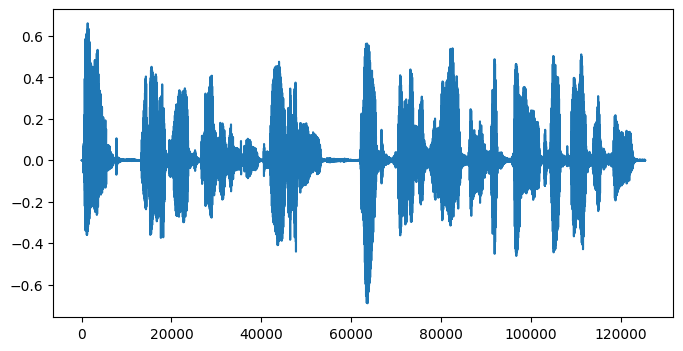

In [ ]:
import matplotlib.pyplot as plt
# wav 파일 불러오기
## 작성
waveform, sample_rate = torchaudio.load("/kaggle/input/jbnu-2024-ai-competitons/audio_split/test/00001.wav")


## normalize -> 32비트 float으로 변환
print(waveform.shape)
print(sample_rate)
_,ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(waveform[0, :])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

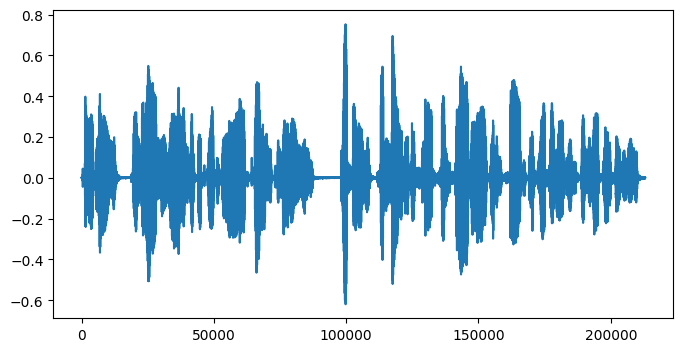

In [ ]:
# train_fake_001.wav
fdata, fsr = torchaudio.load("/kaggle/input/jbnu-2024-ai-competitons/audio_split/train/fake/000001.wav")
_,ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fdata[0, :])
plt.show

In [ ]:
import torchaudio.transforms as AT
#spectrogram, melspectrogram
n_fft = int(np.ceil(0.025 * fsr))
win_length = int(np.ceil(0.025 * fsr))
hop_length = int(np.ceil(0.01 * fsr))
print(n_fft, win_length, hop_length)

spectrogram = nn.Sequential(
    AT.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length
    ),
    AT.AmplitudeToDB()
)

mel_spectrogram = nn.Sequential(
    AT.MelSpectrogram(
        sample_rate=fsr,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=80
    ),
    AT.AmplitudeToDB()
)
fspec = spectrogram(fdata)
fmel = mel_spectrogram(fdata)
print(fspec.shape, fmel.shape)

552 552 221
torch.Size([1, 277, 964]) torch.Size([1, 80, 964])


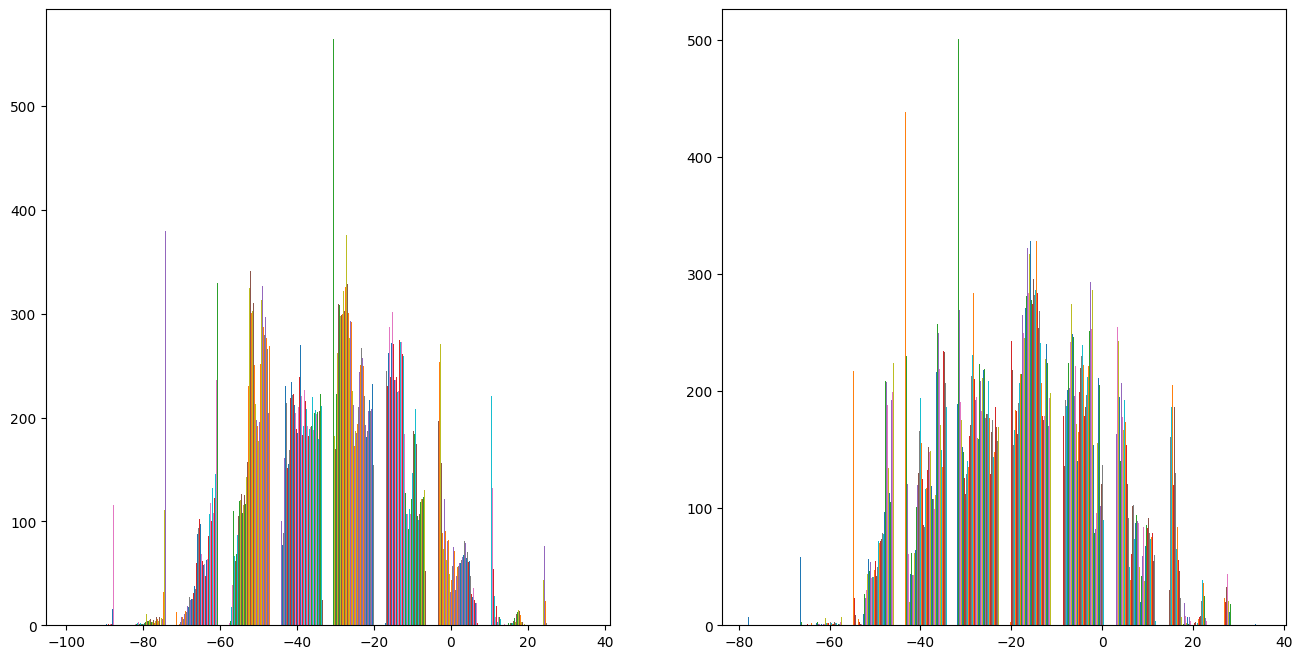

In [ ]:
# fake
_,ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist(fspec[0])
ax[1].hist(fmel[0])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

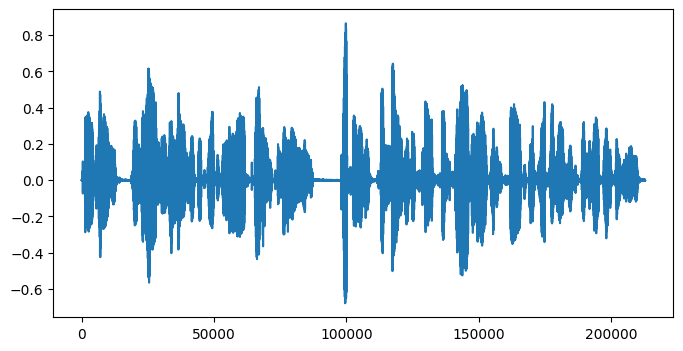

In [ ]:
# train_real_001.wav
rdata, rsr = torchaudio.load("/kaggle/input/jbnu-2024-ai-competitons/audio_split/train/real/LJ001-0001.wav")
_,ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(rdata[0, :])
plt.show

In [ ]:
n_fft = int(np.ceil(0.025 * fsr))
win_length = int(np.ceil(0.025 * fsr))
hop_length = int(np.ceil(0.01 * fsr))
print(n_fft, win_length, hop_length)

spectrogram = nn.Sequential(
    AT.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length
    ),
    AT.AmplitudeToDB()
)

mel_spectrogram = nn.Sequential(
    AT.MelSpectrogram(
        sample_rate=rsr,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=80
    ),
    AT.AmplitudeToDB()
)
rspec = spectrogram(rdata)
rmel = mel_spectrogram(rdata)
print(rspec.shape, rmel.shape)

552 552 221
torch.Size([1, 277, 964]) torch.Size([1, 80, 964])


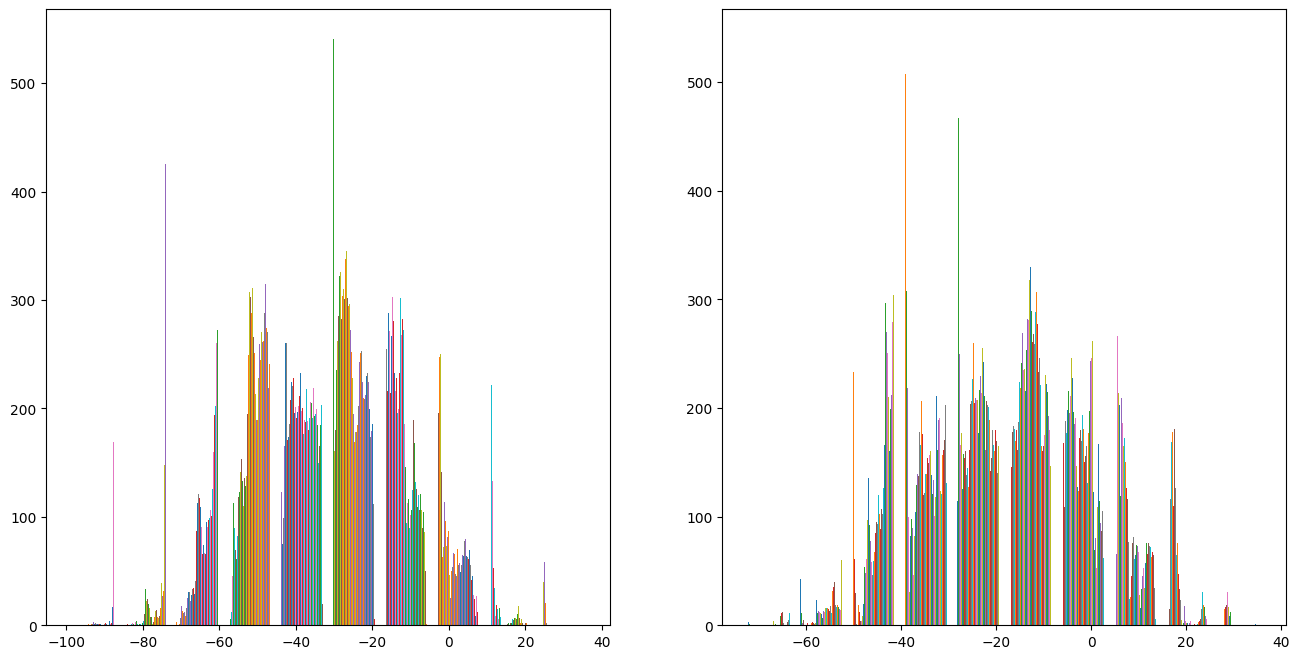

In [ ]:
# real
_,ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist(rspec[0])
ax[1].hist(rmel[0])
plt.show()
#https://ahnjg.tistory.com/93"

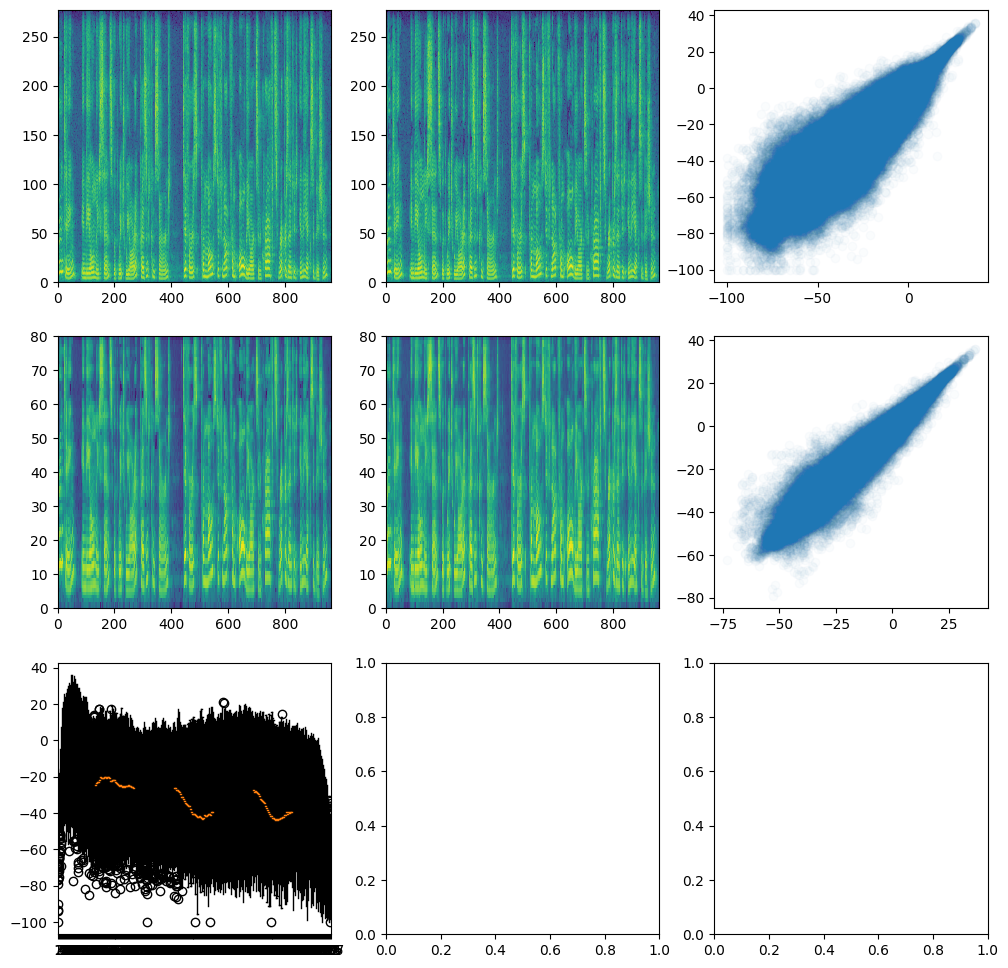

In [ ]:
#########################
# fspec, fmel
# rspec, rmel
_,ax = plt.subplots(3, 3, figsize=(12, 12))
ax[0, 0].pcolor(fspec[0])
ax[0, 1].pcolor(rspec[0])
ax[0, 2].scatter(rspec[0], fspec[0], alpha=  0.02)
ax[1, 0].pcolor(rmel[0])
ax[1, 1].pcolor(fmel[0])
ax[1, 2].scatter(rmel[0], fmel[0], alpha=  0.02)
ax[2, 0].boxplot(fspec[0])
plt.show()

In [ ]:
fspec.shape

torch.Size([1, 277, 964])

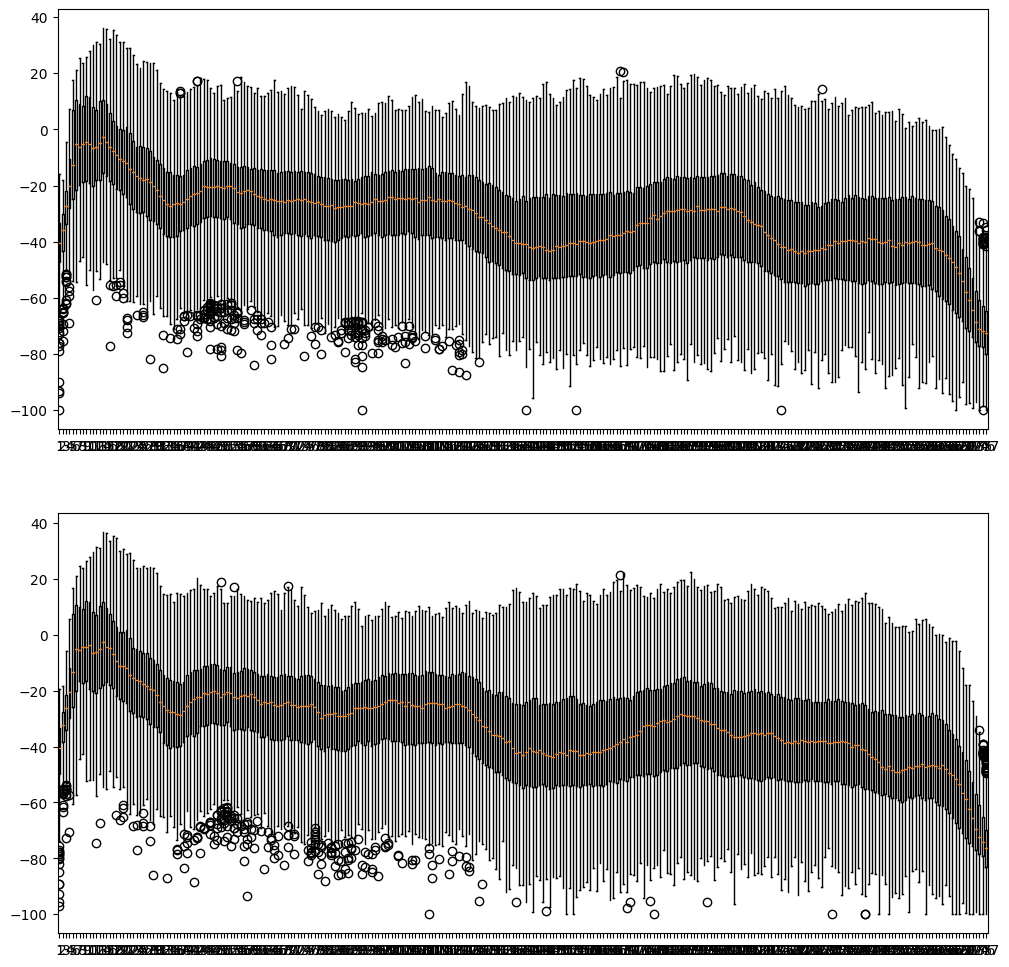

In [ ]:
_,ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].boxplot(fspec[0])
ax[1].boxplot(rspec[0])
plt.show()

![image.png](attachment:2e1a5bad-5770-4d96-bbc4-a1e50304d6f6.png)

텐서의 속성(Attribute)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

텐서의 속성은 텐서의 모양(shape), 자료형(datatype) 및 어느 장치에 저장되는지를 나타냄



In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


텐서 연산(Operation)


전치(transposing), 인덱싱(indexing), 슬라이싱(slicing), 수학 계산, 선형 대수,
임의 샘플링(random sampling) 등, 100가지 이상의 텐서 연산들이 존재함

각 연산들은 (일반적으로 CPU보다 빠른) GPU에서 실행할 수 있음

기본적으로 텐서는 CPU에 생성됨

.to 메소드를 사용하면 (GPU의 가용성(availability)을 확인한 뒤)
GPU로 텐서를 명시적으로 이동할 수 있음

In [ ]:
# 작성
# GPU가 존재하면 텐서를 이동합니다
if torch.cuda.is_available():
    tensor = tensor.to("cuda")
    print(f'Device tensor is started on: {tensor.device}')


##

Device tensor is started on: cuda:0


**NumPy식의 표준 인덱싱과 슬라이싱:**

In [ ]:
## 작성

tensor = torch.ones(4,4)
print(f'First row: {tensor[0]}')
print(f'First column: {tensor[:, 0]}')
print(f'last column: {tensor[..., -1]}')
tensor[:,1] = 0
print(tensor)

##

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**텐서 합치기** ``torch.cat`` 을 사용하여 주어진 차원에 따라 일련의 텐서를 연결할 수 있음


In [ ]:
# 작성
#t1 = torch.cat([tensor, tensor, tensor], dim=1)
t1 = torch.cat([tensor, tensor, tensor], dim=0)
print(t1)
##


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**산술 연산(Arithmetic operations)**



In [ ]:
## 작성
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)
print(y3)


# 요소별 곱
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out = z3)
print(z3)


##

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


텐서의 모든 값을 하나로 집계(aggregate)할 수 있음. 예를 들어 sum()을 활용

item() 메소드를 통해 값을 취할 수 있음



In [ ]:
## 작성
print(tensor)
agg = tensor.sum()
print(agg)
print(agg.item())

agg2 = tensor.sum(dim=0)
print(agg2)

agg3 = tensor.sum(dim=1)
print(agg3)
## 작성

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor(12.)
12.0
tensor([4., 0., 4., 4.])
tensor([3., 3., 3., 3.])



Dataset과 DataLoader
==========================================================================
데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있음


더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적

PyTorch는 ``torch.utils.data.DataLoader`` 와 ``torch.utils.data.Dataset`` 의 두 가지 데이터 기본 요소를
제공하여 미리 준비해된(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 해줌


``Dataset`` 은 샘플과 정답(label)을 저장하고, ``DataLoader`` 는 ``Dataset`` 을 샘플에 쉽게 접근할 수 있도록
순회 가능한 객체(iterable)로 감싸는 형태

``Dataset`` 은 데이터을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 수행함

Dataset 클래스는 반드시 3개 함수를 구현해야 함: `__init__`, `__len__`, and `__getitem__`.

`__init__` 함수는 Dataset 객체가 생성될 때 한 번만 실행됨

`__len__` 함수는 데이터셋의 샘플 개수를 반환

`__getitem__` 함수는 주어진 인덱스 ``idx`` 에 해당하는 샘플을 데이터셋에서 불러오고 반환함


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class AudioDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            directory_or_path_list: Union[Union[str, Path], List[Union[str, Path]]],
            sample_rate: int = 16_000,
            normalize: bool = True,
            real: str = 'real',
    ) -> None:
        super().__init__()

        self.sample_rate = sample_rate
        self.normalize = normalize
        if real == 'real':
            directory_or_path_list = directory_or_path_list * 7
        paths = directory_or_path_list
        self._paths = paths

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        path = self._paths[index]
        waveform, sample_rate = torchaudio.load(path, normalize=self.normalize)
        if sample_rate != self.sample_rate:
            transform = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = transform(waveform)
        return waveform, sample_rate

    def __len__(self) -> int:
        return len(self._paths)


class PadDataset(torch.utils.data.Dataset):

    def __init__(self, dataset: torch.utils.data.Dataset, cut: int = 64600, label=None):
        self.dataset = dataset
        self.cut = cut  # max 4 sec
        self.label = label

    def __getitem__(self, index):
        waveform, sample_rate = self.dataset[index]
        waveform = waveform.squeeze(0)
        waveform_len = waveform.shape[0]
        if waveform_len >= self.cut:
            if self.label is None:
                return waveform[:self.cut], sample_rate
            else:
                return waveform[:self.cut], sample_rate, self.label
        # need to pad
        num_repeats = int(self.cut / waveform_len)+1
        padded_waveform = torch.tile(waveform, (1, num_repeats))[
            :, :self.cut][0]

        if self.label is None:
            return padded_waveform, sample_rate
        else:
            return padded_waveform, sample_rate, self.label

    def __len__(self):
        return len(self.dataset)


def load_dataset(
        path: Union[Path, str],
        pad: bool = False,
        train: str = 'train',
        real: str = 'real',
        label: Optional[int] = None,
):

    cur_path = "{}/{}/{}".format(path,train,real)

    paths = find_wav_files(cur_path)
    if paths is None:
        raise IOError(f"Could not load files from {path}!")

    print(f"Loading data from {path}...!")

    train_dataset = AudioDataset(
        paths, real=real)
    if pad:
        train_dataset = PadDataset(train_dataset, label=label)

    return train_dataset


db_dir = '/kaggle/input/jbnu-2024-ai-competitons/audio_split'
real_dataset_train = load_dataset(
        db_dir,
        pad=True,
        train='train',
        real='real',
        label=1,
)
print("Completed")

Loading data from /kaggle/input/jbnu-2024-ai-competitons/audio_split...!
Completed


**DataLoader로 학습용 데이터 준비하기**




모델을 학습할 때, 일반적으로 샘플들을 미니배치(minibatch)로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서(shuffle) 과적합(overfit)을 막음

``DataLoader`` 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)임

num_workers: 데이터를 불러오기 위해 사용하는 subprocess의 수

drop_last: 데이터셋의 크기가 배치 사이즈로 나누었을 때 딱 떨어지지 않는 경우 마지막 배치에 대해서는 drop

In [ ]:
## 작성
train_loader = DataLoader(dataset=real_dataset_train, batch_size=128, shuffle=True,  drop_last=True, num_workers=4)
print(1)

1


**DataLoader를 통해 순회하기(iterate)**


``DataLoader`` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있음

In [ ]:
for epoch in range(10):
    print("epoch {}:".format(epoch))
    for i, (batch_x, _, batch_y) in enumerate(train_loader):
        print("iteration {}:".format(i))
        print(batch_x.shape)
        print(batch_y.shape)
        if i == 2:
            break
    break

epoch 0:
iteration 0:
torch.Size([128, 64600])
torch.Size([128])
iteration 1:
torch.Size([128, 64600])
torch.Size([128])
iteration 2:
torch.Size([128, 64600])
torch.Size([128])


신경망 모델 구성하기
==========================================================================

신경망은 데이터에 대한 연산을 수행하는 계층(layer)/모듈(module)로 구성되어 있음

`torch.nn` 네임스페이스는 신경망을 구성하는데 필요한 모든 구성 요소를 제공

PyTorch의 모든 모듈은 `nn.Module`의 하위 클래스(subclass)임

신경망은 다수의 계층(layer)로 구성된 모듈


학습을 위한 장치 얻기
------------------------------------------------------------------------------------------

가능한 경우 GPU와 같은 하드웨어 가속기에서 모델 학습 수행

`torch.cuda` 를 사용할 수 있는지 확인하고 그렇지 않으면 CPU를 계속 사용

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


클래스 정의하기
------------------------------------------------------------------------------------------

신경망 모델을 ``nn.Module`` 의 하위클래스로 정의하고, ``__init__`` 에서 신경망 계층들을 초기화함

``nn.Module`` 을 상속받은 모든 클래스는 ``forward`` 메소드에 입력 데이터에 대한 연산들을 구현

모델에 대한 학습을 수행하는 backward()는 자동적으로 구현됨

In [ ]:
## 작성
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool1d(9, 9)
        self.gap = nn.AdaptiveAvgPool1d(1)

        self.conv1 = nn.Conv1d(1, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(16, 16, 3, 1, 1)
        self.bn2 = nn.BatchNorm1d(16)

        self.conv3 = nn.Conv1d(16, 16, 3, 1, 1)
        self.bn3 = nn.BatchNorm1d(16)

        self.conv4 = nn.Conv1d(16, 16, 3, 1, 1)
        self.bn4 = nn.BatchNorm1d(16)

        self.conv5 = nn.Conv1d(16, 16, 3, 1, 1)
        self.bn5 = nn.BatchNorm1d(16)

        self.conv6 = nn.Conv1d(16, 16, 3, 1, 1)
        self.bn6 = nn.BatchNorm1d(16)

        self.fc1 = nn.Linear(16, 16)
        self.bn7 = nn.BatchNorm1d(16)

        self.fc2 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        # N 배치의 크기, T
        N, T = x.shape
        x = x.reshape(N, 1, T)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.gap(self.relu(self.bn6(self.conv6(x))))
        x = x.reshape(N, 16)

        x = self.relu(self.bn7(self.fc1(x)))
        x = self.fc2(x)
        x = self.softmax(x)

        return x
##

criterion = torch.nn.CrossEntropyLoss() # 교차 엔트로피 오차
cur_network = network().cuda()                     # 학습률
optim = torch.optim.Adam(cur_network.parameters(), lr = 0.0001, weight_decay = 0.0001) # 최적화
cur_network.train()
for epoch in range(10):
            for i, (batch_x, _, batch_y) in enumerate(train_loader):
                    # 음성데이터   # 진짠지 가짠지
                batch_size = batch_x.size(0)

                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

                batch_out = cur_network(batch_x)
                batch_loss = criterion(batch_out, batch_y)

                _, batch_pred = batch_out.max(dim=1)

                if i % (train_loader.__len__() // 20) == 0:
                    print(f"[{epoch:04d}] {i}/{train_loader.__len__()}: {batch_loss}")

                optim.zero_grad()
                batch_loss.backward()
                optim.step()


[0000] 0/429: 0.6124729514122009
[0000] 21/429: 0.5914859771728516
[0000] 42/429: 0.5824697613716125
[0000] 63/429: 0.5762931704521179
[0000] 84/429: 0.567085862159729
[0000] 105/429: 0.5607785582542419
[0000] 126/429: 0.5458170771598816
[0000] 147/429: 0.5362063646316528
[0000] 168/429: 0.5335216522216797
[0000] 189/429: 0.5272353291511536
[0000] 210/429: 0.5237088203430176
[0000] 231/429: 0.5155469179153442
[0000] 252/429: 0.5049605965614319
[0000] 273/429: 0.5028864741325378
[0000] 294/429: 0.4935344159603119
[0000] 315/429: 0.4852118194103241
[0000] 336/429: 0.48490777611732483
[0000] 357/429: 0.47658881545066833
[0000] 378/429: 0.4736834764480591
[0000] 399/429: 0.4670826494693756
[0000] 420/429: 0.4668091833591461
[0001] 0/429: 0.4556248188018799
[0001] 21/429: 0.45434483885765076
[0001] 42/429: 0.4524106979370117
[0001] 63/429: 0.4481618404388428
[0001] 84/429: 0.4431508779525757
[0001] 105/429: 0.4353969097137451
[0001] 126/429: 0.4368480443954468
[0001] 147/429: 0.433086395263